In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install -q keras

**Setting up the environment**


In [5]:
import keras

Using TensorFlow backend.


In [0]:
import numpy as np
import pandas as pd
import os
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import * # grab all the symbols
from fastai.vision import *

**Fettching the Data**


torch.Size([3, 208, 176])


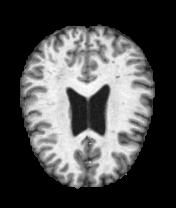

In [7]:
brain_img = open_image(Path('/content/drive/My Drive/Alzheimers/Alzheimer_s Dataset/test/VeryMildDemented/27 (33).jpg'))
print(brain_img.shape)
brain_img

In [0]:
PATH = Path('/content/drive/My Drive/Alzheimers/Alzheimer_s Dataset/')

**Image Transformation**

In [0]:
transform = get_transforms(max_rotate=7.5, max_zoom=1.15, max_lighting=0.15, max_warp=0.15, p_affine=0.8, p_lighting = 0.8, 
                           xtra_tfms= [pad(mode='zeros'), symmetric_warp(magnitude=(-0.1,0.1)), cutout(n_holes=(1,3), length=(5,5))])

**Resizing for pre-traning**


In [0]:
data = ImageDataBunch.from_folder(PATH, train="train/",
                                  test="test/",
                                  valid_pct=.4,
                                  ds_tfms=transform,
                                  size=112,bs=32, 
                                  ).normalize(imagenet_stats)

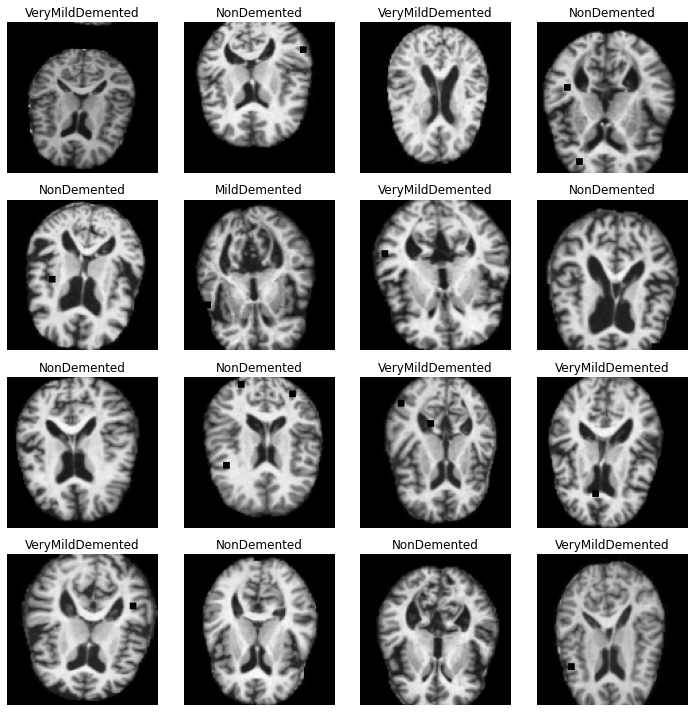

In [11]:
data.show_batch(rows=4, figsize=(10,10))

**num of cases per-class**
copy pasted from here: https://forums.fast.ai/t/get-value-counts-from-a-imagedatabunch/38784

In [12]:
#value count of the classes
Category.__eq__ = lambda self, that: self.data == that.data
Category.__hash__ = lambda self: hash(self.obj)
Counter(data.train_ds.y)

Counter({Category 0: 423, Category 1: 32, Category 2: 1589, Category 3: 1029})

**Transfer Learning**

In [13]:
learn = cnn_learner(data, models.vgg16_bn, metrics=error_rate, wd=1e-1) 
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.850700,1.356655,0.509277,00:31
1,1.292713,0.920592,0.445801,00:31
2,1.025316,0.875532,0.406738,00:31
3,0.935266,0.880724,0.433105,00:31


In [0]:
Model_Path = Path('/kaggle/working/Alzheimer-stage-classifier-model/')
learn.model_dir = Model_Path
learn.save('checkpoint-1')

In [0]:
learn.load('checkpoint-1');

In [16]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.923570,0.857313,0.414062,00:32
1,0.873082,0.829402,0.385742,00:31
2,0.827486,0.802225,0.374023,00:31
3,0.787610,0.787841,0.372559,00:31


In [0]:
learn.save('checkpoint-2')

In [18]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


**Transformation and image normalization for full size image**


In [0]:
transform = get_transforms(max_rotate=7.5, max_zoom=1.15, max_lighting=0.15, max_warp=0.15, p_affine=0.8, p_lighting = 0.8, xtra_tfms= [pad(mode='zeros'), symmetric_warp(magnitude=(-0.1,0.1)), cutout(n_holes=(1,6), length=(5,20))])

In [0]:
data = ImageDataBunch.from_folder(PATH, train="train/",
                                  valid="train/",
                                  test="test/",
                                  valid_pct=.2,
                                  ds_tfms=transform,
                                  size=224,bs=32, 
                                  ).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.vgg16_bn, pretrained=False, metrics=[error_rate, FBeta(average='weighted')], wd=1e-1)
Model_Path = Path('/kaggle/working/Alzheimer-stage-classifier-model/')
learn.model_dir = Model_Path
learn.load('checkpoint-2');

epoch,train_loss,valid_loss,error_rate,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


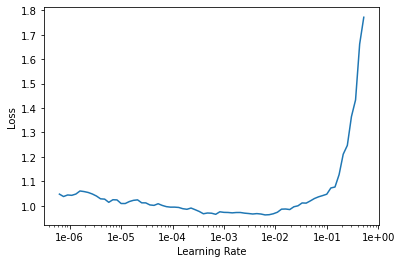

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(17, max_lr=5e-4)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.866447,0.803251,0.357422,0.625117,01:19
1,0.778108,0.690906,0.308594,0.677148,01:19
2,0.697036,0.931955,0.396484,0.579244,01:19
3,0.662636,0.697750,0.288086,0.698854,01:20
4,0.574039,0.618801,0.255859,0.746117,01:19
5,0.482461,0.503112,0.220703,0.772984,01:19
6,0.443857,1.042963,0.405273,0.561470,01:18
7,0.368274,0.442570,0.178711,0.814618,01:23
8,0.302823,0.451564,0.191406,0.805951,01:23
9,0.219807,0.288057,0.111328,0.887146,01:24


In [0]:
learn.save('checkpoint-3')

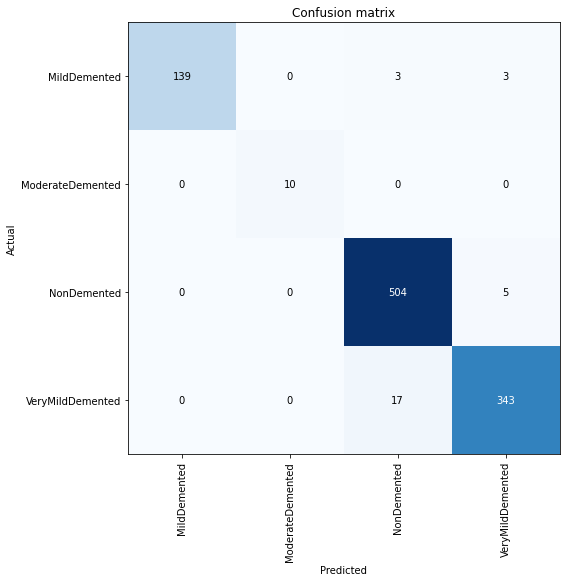

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(8,8))

**F-Beta Score**

In [0]:
transform = get_transforms(max_rotate=7.5, max_zoom=1.15, max_lighting=0.15, max_warp=0.15, p_affine=0.8, p_lighting = 0.8, xtra_tfms= [pad(mode='zeros'), symmetric_warp(magnitude=(-0.1,0.1))])

In [27]:
data_test =  ImageDataBunch.from_folder(PATH,
                                  train="test/",#"train/",
                                  valid="test/",
                                  valid_pct=0.3,
                                  ds_tfms=transform,
                                  size=224,bs=32, 
                                  ).normalize(imagenet_stats)
ev = learn.validate(data_test.train_dl,metrics=[error_rate, FBeta(average='weighted')])
print('Results from test set \tError rate:', float(ev[1]), '\tF Beta Score: ', float(ev[2]))

Results from test set 	Error rate: 0.0491071417927742 	F Beta Score:  0.9506938457489014
